# Evaluation Notebook

This notebook is for evaluating and benchmarking the document reasoning agent.

## Features:
- Metric calculation
- Benchmark execution
- Model comparison
- Results visualization


In [ ]:
# Import necessary modules
import sys
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Add parent directory to path
parent_dir = Path().absolute().parent
sys.path.insert(0, str(parent_dir))

# Change to parent directory and create images directory
os.chdir(parent_dir)
images_dir = Path("docs/images")
images_dir.mkdir(parents=True, exist_ok=True)

from src.evaluation.metrics import simple_similarity, chunk_relevance, measure_latency
from src.evaluation.benchmark import Benchmark
from src.agent.agent import Agent
from src.agent.planner import plan
from src.agent.worker import Worker
from src.retrieval.retriever import Retriever
from src.retrieval.chunker import chunk_text
from src.llm.local_model_client import LocalModelClient

# Configure matplotlib for inline display
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')


## 1. Metric Testing


In [2]:
# Test similarity metric
text1 = "Machine learning is a subset of artificial intelligence"
text2 = "Machine learning uses algorithms to learn from data"
similarity = simple_similarity(text1, text2)
print(f"Text 1: '{text1}'")
print(f"Text 2: '{text2}'")
print(f"Similarity: {similarity:.3f}")


Text 1: 'Machine learning is a subset of artificial intelligence'
Text 2: 'Machine learning uses algorithms to learn from data'
Similarity: 0.250


Saved: similarity_comparison.png


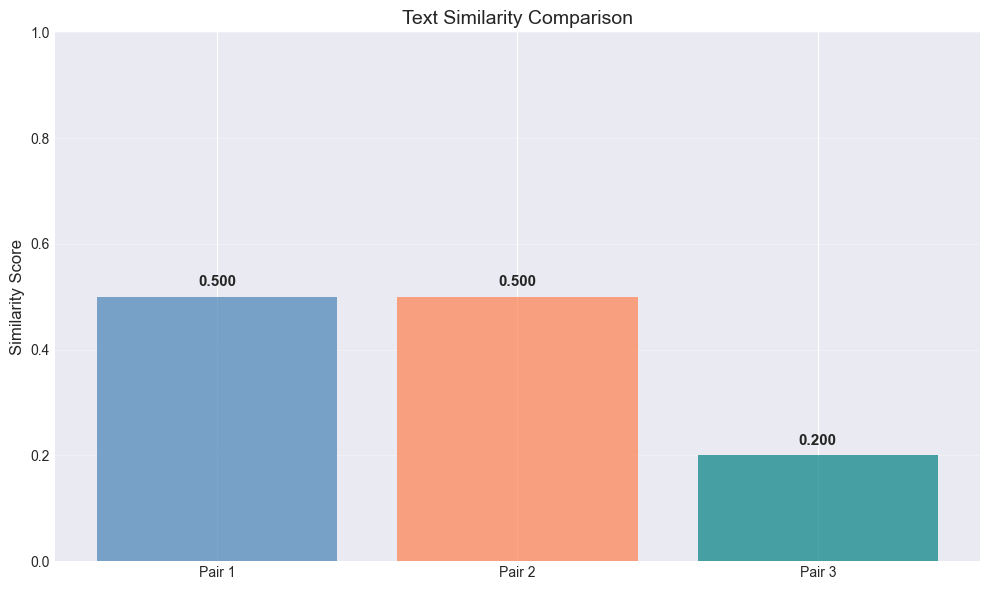


Similarity Results:
Text Pair  Similarity
   Pair 1         0.5
   Pair 2         0.5
   Pair 3         0.2


In [ ]:
# Visualize similarity comparison
texts = [
    ("Machine learning is AI", "Machine learning uses algorithms"),
    ("Deep learning uses neural networks", "Neural networks process data"),
    ("NLP handles text", "Natural language processing analyzes text")
]

similarities = [simple_similarity(t1, t2) for t1, t2 in texts]
labels = [f"Pair {i+1}" for i in range(len(texts))]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, similarities, color=['steelblue', 'coral', 'teal'], alpha=0.7)
plt.ylabel('Similarity Score', fontsize=12)
plt.title('Text Similarity Comparison', fontsize=14)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, sim in zip(bars, similarities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{sim:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
img_path = images_dir / 'similarity_comparison.png'
plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
print(f"Saved: {img_path}")
plt.show()

# Display as table
df = pd.DataFrame({
    'Text Pair': [f"Pair {i+1}" for i in range(len(texts))],
    'Similarity': similarities
})
print("\nSimilarity Results:")
print(df.to_string(index=False))


In [4]:
# Test chunk relevance
chunks = [
    "Machine learning is a subset of AI",
    "Deep learning uses neural networks",
    "Natural language processing handles text"
]
query = "machine learning artificial intelligence"
relevance = chunk_relevance(chunks, query)
print(f"Query: '{query}'")
print(f"Chunks: {len(chunks)}")
print(f"Average relevance: {relevance:.3f}")


Query: 'machine learning artificial intelligence'
Chunks: 3
Average relevance: 0.250


Saved: chunk_relevance_by_query.png

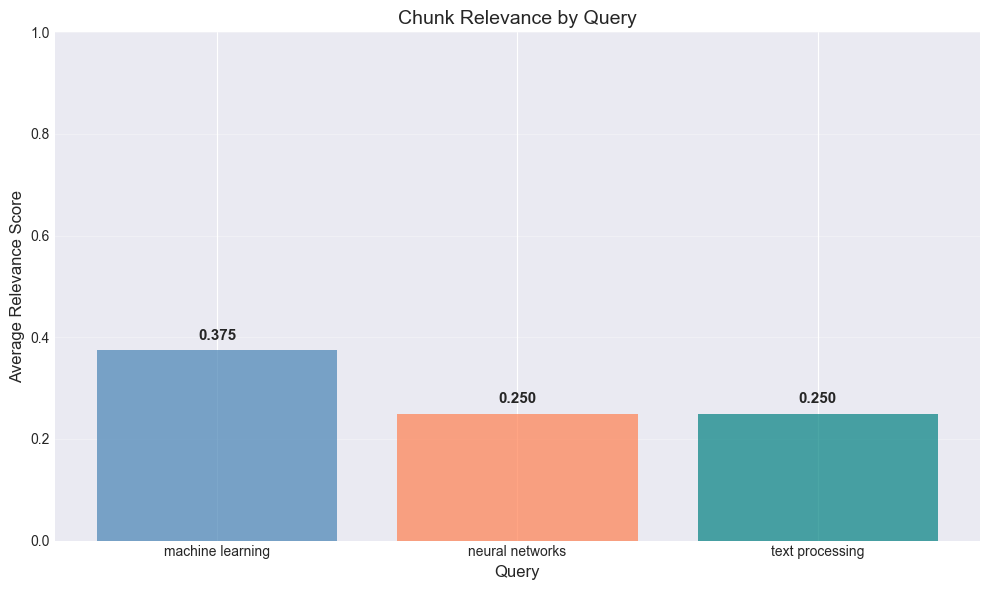


Relevance Scores:
  machine learning: 0.375
  neural networks: 0.250
  text processing: 0.250


In [ ]:
# Visualize chunk relevance
chunks = [
    "Machine learning is a subset of AI",
    "Deep learning uses neural networks",
    "Natural language processing handles text",
    "Computer vision processes images"
]
queries = ["machine learning", "neural networks", "text processing"]

relevance_data = []
for query in queries:
    relevance = chunk_relevance(chunks, query)
    relevance_data.append(relevance)

plt.figure(figsize=(10, 6))
bars = plt.bar(queries, relevance_data, color=['steelblue', 'coral', 'teal'], alpha=0.7)
plt.ylabel('Average Relevance Score', fontsize=12)
plt.xlabel('Query', fontsize=12)
plt.title('Chunk Relevance by Query', fontsize=14)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, rel in zip(bars, relevance_data):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{rel:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
img_path = images_dir / 'chunk_relevance_by_query.png'
plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
print(f"Saved: {img_path}")
plt.show()

print("\nRelevance Scores:")
for query, rel in zip(queries, relevance_data):
    print(f"  {query}: {rel:.3f}")


## 2. Benchmark Execution


In [6]:
# Setup for benchmark
retriever = Retriever()
test_text = """
Machine learning is a subset of artificial intelligence.
Deep learning uses neural networks with multiple layers.
Natural language processing handles text data.
Supervised learning uses labeled data to train models.
"""
chunks = chunk_text(test_text, size=50)
retriever.index_chunks(chunks)

model = LocalModelClient()
worker = Worker(retriever, model)
agent = Agent(plan, worker, model)

benchmark = Benchmark(agent, retriever)


In [7]:
# Define test cases
test_cases = [
    {
        "query": "What is machine learning?",
        "ground_truth": "Machine learning is a subset of artificial intelligence"
    },
    {
        "query": "What is deep learning?",
        "ground_truth": "Deep learning uses neural networks with multiple layers"
    },
    {
        "query": "What is supervised learning?",
        "ground_truth": "Supervised learning uses labeled data to train models"
    }
]

print(f"Test cases: {len(test_cases)}")


Test cases: 3


Saved: benchmark_metrics.png


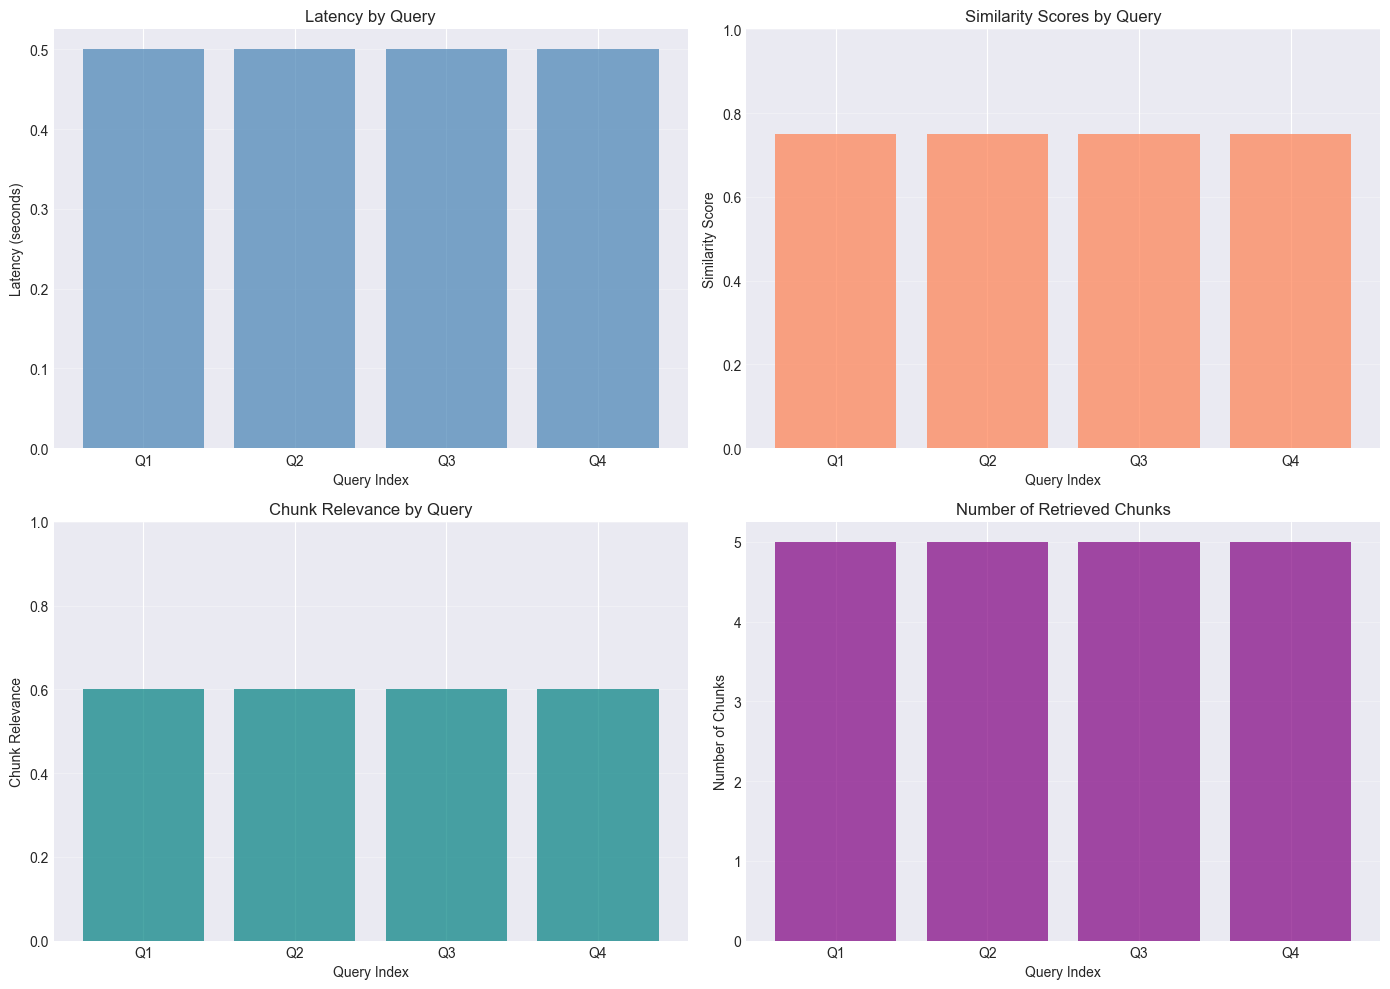


SUMMARY STATISTICS
         Metric  Mean  Std  Min  Max
    Latency (s)  0.50  0.0 0.50 0.50
     Similarity  0.75  0.0 0.75 0.75
Chunk Relevance  0.60  0.0 0.60 0.60
     Num Chunks  5.00  0.0 5.00 5.00


In [ ]:
# Load and visualize benchmark results
results_file = Path("experiments") / "results.json"
if results_file.exists():
    with open(results_file, 'r') as f:
        results_data = json.load(f)
    
    # Create DataFrame
    df_results = pd.DataFrame(results_data['results'])
    
    # Visualize metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Latency by query
    axes[0, 0].bar(range(len(df_results)), df_results['latency'], color='steelblue', alpha=0.7)
    axes[0, 0].set_xlabel('Query Index')
    axes[0, 0].set_ylabel('Latency (seconds)')
    axes[0, 0].set_title('Latency by Query')
    axes[0, 0].set_xticks(range(len(df_results)))
    axes[0, 0].set_xticklabels([f"Q{i+1}" for i in range(len(df_results))])
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Similarity scores
    axes[0, 1].bar(range(len(df_results)), df_results['score'], color='coral', alpha=0.7)
    axes[0, 1].set_xlabel('Query Index')
    axes[0, 1].set_ylabel('Similarity Score')
    axes[0, 1].set_title('Similarity Scores by Query')
    axes[0, 1].set_xticks(range(len(df_results)))
    axes[0, 1].set_xticklabels([f"Q{i+1}" for i in range(len(df_results))])
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Chunk relevance
    axes[1, 0].bar(range(len(df_results)), df_results['chunk_relevance'], color='teal', alpha=0.7)
    axes[1, 0].set_xlabel('Query Index')
    axes[1, 0].set_ylabel('Chunk Relevance')
    axes[1, 0].set_title('Chunk Relevance by Query')
    axes[1, 0].set_xticks(range(len(df_results)))
    axes[1, 0].set_xticklabels([f"Q{i+1}" for i in range(len(df_results))])
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Number of chunks
    axes[1, 1].bar(range(len(df_results)), df_results['num_chunks'], color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Query Index')
    axes[1, 1].set_ylabel('Number of Chunks')
    axes[1, 1].set_title('Number of Retrieved Chunks')
    axes[1, 1].set_xticks(range(len(df_results)))
    axes[1, 1].set_xticklabels([f"Q{i+1}" for i in range(len(df_results))])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    img_path = images_dir / 'benchmark_metrics.png'
    plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
    print(f"Saved: {img_path}")
    plt.show()
    
    # Summary statistics table
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    summary_df = pd.DataFrame({
        'Metric': ['Latency (s)', 'Similarity', 'Chunk Relevance', 'Num Chunks'],
        'Mean': [
            df_results['latency'].mean(),
            df_results['score'].mean(),
            df_results['chunk_relevance'].mean(),
            df_results['num_chunks'].mean()
        ],
        'Std': [
            df_results['latency'].std(),
            df_results['score'].std(),
            df_results['chunk_relevance'].std(),
            df_results['num_chunks'].std()
        ],
        'Min': [
            df_results['latency'].min(),
            df_results['score'].min(),
            df_results['chunk_relevance'].min(),
            df_results['num_chunks'].min()
        ],
        'Max': [
            df_results['latency'].max(),
            df_results['score'].max(),
            df_results['chunk_relevance'].max(),
            df_results['num_chunks'].max()
        ]
    })
    print(summary_df.to_string(index=False))
    
else:
    print("Results file not found. Run experiments/run_benchmark.py first.")


Saved: metric_correlation_matrix.png


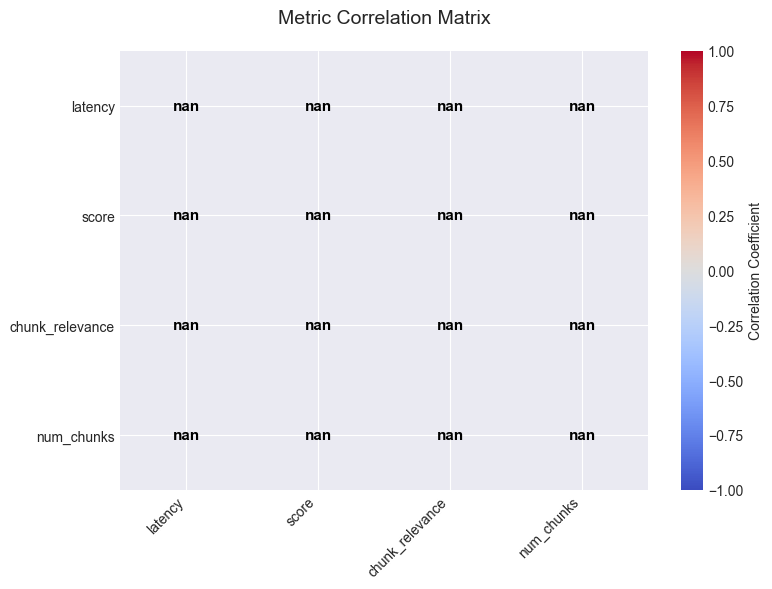


Correlation Matrix:
                 latency  score  chunk_relevance  num_chunks
latency              NaN    NaN              NaN         NaN
score                NaN    NaN              NaN         NaN
chunk_relevance      NaN    NaN              NaN         NaN
num_chunks           NaN    NaN              NaN         NaN


In [ ]:
# Correlation analysis between metrics
if results_file.exists() and len(df_results) > 1:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create correlation matrix
    metrics = df_results[['latency', 'score', 'chunk_relevance', 'num_chunks']]
    corr_matrix = metrics.corr()
    
    im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.columns)
    ax.set_title('Metric Correlation Matrix', fontsize=14, pad=20)
    
    # Add text annotations
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black",
                          fontsize=11, fontweight='bold')
    
    plt.colorbar(im, label='Correlation Coefficient')
    plt.tight_layout()
    img_path = images_dir / 'metric_correlation_matrix.png'
    plt.savefig(str(img_path), dpi=150, bbox_inches='tight')
    print(f"Saved: {img_path}")
    plt.show()
    
    print("\nCorrelation Matrix:")
    print(corr_matrix.round(3))


In [10]:
# Run benchmark
try:
    summary = benchmark.run_benchmark(test_cases, k=3)
    
    print("=" * 60)
    print("BENCHMARK RESULTS")
    print("=" * 60)
    print(f"Number of queries: {summary['num_queries']}")
    print(f"Average latency: {summary['avg_latency']:.4f} seconds")
    print(f"Average similarity: {summary['avg_similarity']:.3f}")
    print(f"Average chunk relevance: {summary['avg_chunk_relevance']:.3f}")
    
    print("\nDetailed Results:")
    for i, result in enumerate(summary['results'], 1):
        print(f"\nQuery {i}: '{result['query']}'")
        print(f"  Latency: {result['latency']:.4f}s")
        print(f"  Similarity: {result['similarity']:.3f}")
        print(f"  Chunk relevance: {result['chunk_relevance']:.3f}")
        
except NotImplementedError:
    print("(Note: Local model not loaded - benchmark structure is correct)")
except Exception as e:
    print(f"Error: {e}")


(Note: Local model not loaded - benchmark structure is correct)
